# scRNA-seq preprocessing using Scanpy

In [20]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

In [21]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.23.5 scipy==1.10.0 pandas==1.5.1 scikit-learn==0.24.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.6


In [22]:
adata = sc.read_10x_mtx(
    './scenicplus/scRNA_preprocessing/scRNA/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False) 

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [24]:
adata.var['feature_types'] = 'Gene Expression'
adata.var['genome'] = 'mmusculus'


In [25]:
adata

AnnData object with n_obs × n_vars = 8588 × 18831
    var: 'gene_ids', 'feature_types', 'genome'

In [26]:
adata.var

,gene_ids,feature_types,genome
Gnai3,ENSMUSG00000000001,Gene Expression,mmusculus
Cdc45,ENSMUSG00000000028,Gene Expression,mmusculus
H19,ENSMUSG00000000031,Gene Expression,mmusculus
Scml2,ENSMUSG00000000037,Gene Expression,mmusculus
Apoh,ENSMUSG00000000049,Gene Expression,mmusculus
...,...,...,...
Olfr50,ENSMUSG00000111021,Gene Expression,mmusculus
Olfr1328,ENSMUSG00000111259,Gene Expression,mmusculus
1700027J07Rik,ENSMUSG00000111422,Gene Expression,mmusculus
Olfr157,ENSMUSG00000111611,Gene Expression,mmusculus


# Basic quality control

In [28]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1 cells that have less than 200 genes expressed
filtered out 3371 genes that are detected in less than 3 cells


In [29]:
sc.external.pp.scrublet(adata) #estimates doublets


Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/NouroddinSotoudehChafi/my_env/my_env/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 28.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%
    Scrublet finished (0:00:05)


In [30]:
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

View of AnnData object with n_obs × n_vars = 8580 × 15460
    obs: 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'scrublet'

Trying to set attribute `.var` of view, copying.
/Users/NouroddinSotoudehChafi/my_env/my_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gene_ids' as categorical
/Users/NouroddinSotoudehChafi/my_env/my_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/Users/NouroddinSotoudehChafi/my_env/my_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` para

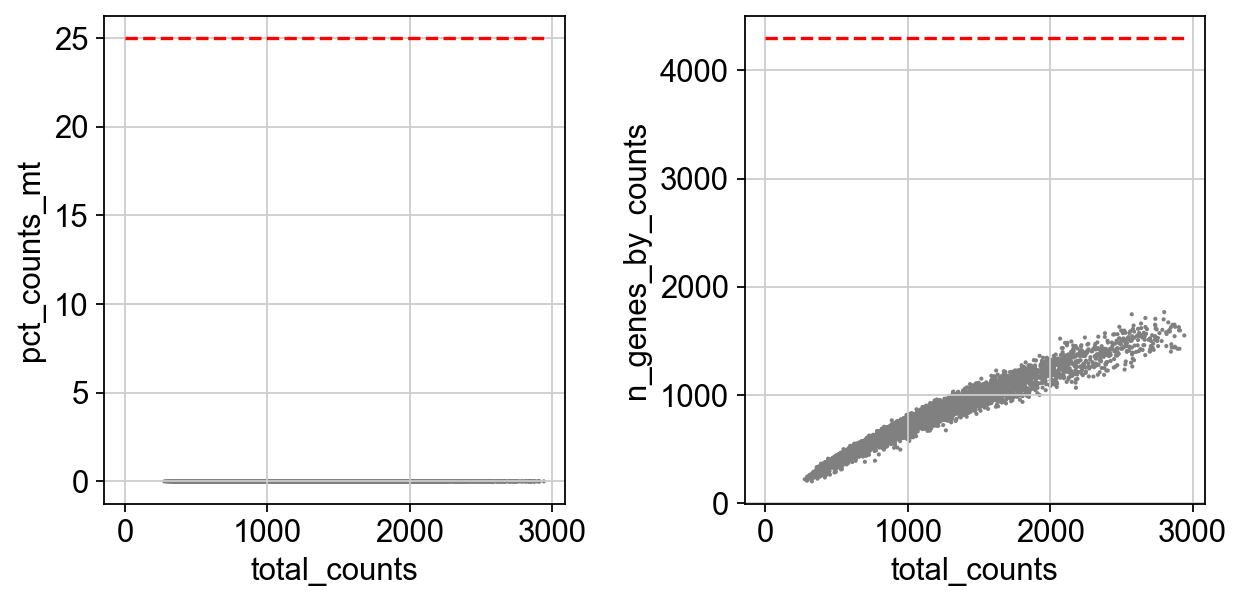

In [31]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
import matplotlib.pyplot as plt
mito_filter = 25
n_counts_filter = 4300
fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False)
#draw horizontal red lines indicating thresholds.
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

In [32]:
adata = adata[adata.obs.n_genes_by_counts < n_counts_filter, :]
adata = adata[adata.obs.pct_counts_mt < mito_filter, :]
adata

View of AnnData object with n_obs × n_vars = 8580 × 15460
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

In [33]:
df1=pd.read_csv('./scenicplus/scRNA_preprocessing/scRNA/metadata_rna.csv', index_col=0)
df2=adata.obs
df1[df1.index.isin(df2.index)].reindex(df2.index)['Main_cell_type'].values

array(['Chondrocytes & osteoblasts', 'Intermediate Mesoderm',
       'Primitive erythroid lineage', ..., 'Chondrocytes & osteoblasts',
       'Intermediate Mesoderm', 'Chondrocytes & osteoblasts'],
      dtype=object)

In [34]:
adata.obs['celltype'] = df1[df1.index.isin(df2.index)].reindex(df2.index)['Main_cell_type'].values

Trying to set attribute `.obs` of view, copying.


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


/Users/NouroddinSotoudehChafi/my_env/my_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


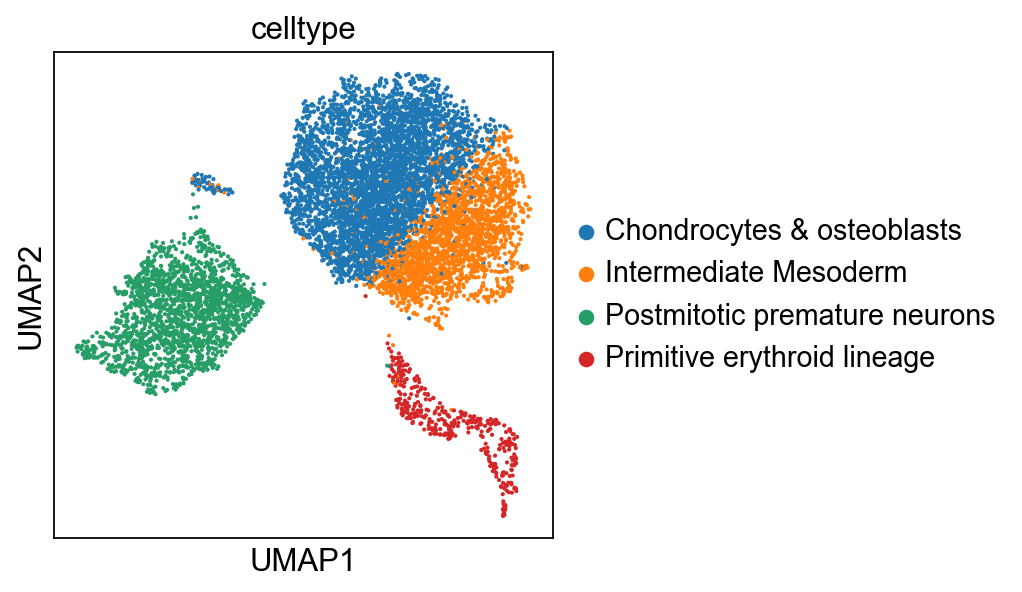

In [36]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'celltype')


In [42]:
adata.write("./scenicplus/scRNA_preprocessing/scRNA/adata.h5ad")


# scATAC-seq preprocessing using pycisTopic

In [1]:
work_dir = "./scenicplus/"

In [3]:
# Path to fragments
fragments_dict = {'D00357': 'fragments_copy.tsv.gz'
#                  'D00646': projDir + 'D00646_fragments_copy.tsv.gz',
#                   'D00623': projDir + 'D00623_fragments_copy.tsv.gz',
#                   'D00625': projDir + 'D00625_fragments_copy.tsv.gz'
                 
                 }  

In [4]:
fragments_dict

{'D00357': 'fragments_copy.tsv.gz'}

# Generate pseudobulk ATAC-seq profiles, call peaks and generate a consensus peak set

In [5]:
# Get metadata from ArchR analysis seurat spatial object file

In [2]:
import pandas as pd

path_to_annotated_rna_loom = work_dir
cell_data = pd.read_csv(path_to_annotated_rna_loom + '/scATAC/metadata_atac.csv', index_col=0)
cell_data

,orig.ident,nCount_Spatial,nFeature_Spatial,Sample,TSSEnrichment,ReadsInTSS,ReadsInPromoter,ReadsInBlacklist,PromoterRatio,PassQC,...,nMonoFrags,nFrags,nDiFrags,BlacklistRatio,cellID_archr,Clusters,predictedCell_Un,predictedGroup_Un,predictedScore_Un,barcodes
AACGTGATAACGTGAT-1___D00357,SeuratProject,2146.083458,3396,D00357,6.562,23816,110738,20220,0.101972,1,...,472149,542984,62918,0.018619,D357#AACGTGATAACGTGAT-1,C1,sci3-me-542.ACGCCATATATATGAGCCA,Postmitotic premature neurons,0.553589,AACGTGATAACGTGAT-1
GCCACATAGATAGACA-1___D00357,SeuratProject,2133.213030,3396,D00357,4.999,10176,48860,13236,0.069379,1,...,309739,352122,37726,0.018795,D357#GCCACATAGATAGACA-1,C1,sci3-me-544.TTCTCATTGTCCATAAGTCC,Postmitotic premature neurons,0.704395,GCCACATAGATAGACA-1
AAACATCGAACGTGAT-1___D00357,SeuratProject,2152.513005,3396,D00357,7.107,15283,68982,12157,0.103450,1,...,290603,333406,38155,0.018232,D357#AAACATCGAACGTGAT-1,C1,sci3-me-163.CTTCATGCTTCAAGCCGAT,Postmitotic premature neurons,0.486827,AAACATCGAACGTGAT-1
AACGTGATATGCCTAA-1___D00357,SeuratProject,2153.121272,3396,D00357,6.426,13671,63886,11756,0.101549,1,...,272414,314556,37481,0.018687,D357#AACGTGATATGCCTAA-1,C1,sci3-me-163.CTTCATGCTTCAAGCCGAT,Postmitotic premature neurons,0.492419,AACGTGATATGCCTAA-1
GCCACATACGCATACA-1___D00357,SeuratProject,2138.133766,3396,D00357,5.533,10219,47870,11785,0.077337,1,...,270679,309489,34536,0.019039,D357#GCCACATACGCATACA-1,C1,sci3-me-544.TTCTCATTGTCCATAAGTCC,Postmitotic premature neurons,0.676042,GCCACATACGCATACA-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATGCCTAAAAACATCG-1___D00357,SeuratProject,2148.745096,3396,D00357,5.591,96,432,100,0.116129,1,...,1611,1860,226,0.026882,D357#ATGCCTAAAAACATCG-1,C1,sci3-me-239.AACGTAATCTCCGTTCGGAT,Intermediate Mesoderm,0.947858,ATGCCTAAAAACATCG-1
AGAGTCAAAAACATCG-1___D00357,SeuratProject,2160.581032,3396,D00357,7.449,79,358,72,0.104862,1,...,1476,1707,208,0.021090,D357#AGAGTCAAAAACATCG-1,C3,sci3-me-229.TAGAACCAATCCGCAAGTTC,Postmitotic premature neurons,0.648375,AGAGTCAAAAACATCG-1
CGCATACAAAACATCG-1___D00357,SeuratProject,2144.936409,3396,D00357,5.743,58,232,61,0.103020,1,...,982,1126,124,0.027087,D357#CGCATACAAAACATCG-1,C2,sci3-me-214.GGAGGTTCTAGCCGGTACC,Chondrocytes & osteoblasts,0.689631,CGCATACAAAACATCG-1
CGAACTTAAAACATCG-1___D00357,SeuratProject,2148.715087,3396,D00357,6.040,61,241,26,0.113146,1,...,931,1065,120,0.012207,D357#CGAACTTAAAACATCG-1,C1,sci3-me-209.TCATGGCTTCTCTGATCAG,Intermediate Mesoderm,0.703253,CGAACTTAAAACATCG-1


In [7]:
cell_data['Sample']= 'D00357'

In [8]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
# target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
# target_url='http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes'
# chromsizes=pd.read_csv(target_url, sep='\t', header=None)

# we use the eidted one for having new name of random and undefined chromosomes too
chromsizes=pd.read_csv("/Users/NouroddinSotoudehChafi/Downloads/extra_analysis/SCENIC+/mm10_chr_size_edited.txt"
                       , sep='\t', header=None)
                       

chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [2]:
work_dir = "./scenicplus/"
# Temp dir
tmp_dir = '/Users/NouroddinSotoudehChafi/'


In [30]:
from pycisTopic.pseudobulk_peak_calling import *

bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'predictedGroup_Un',
                 sample_id_col = 'Sample',
                 chromsizes = chromsizes,
                 bed_path = work_dir + '/scATAC/consensus_peak_calling/pseudobulk_bed_files/',
                 bigwig_path = work_dir + '/scATAC/consensus_peak_calling/pseudobulk_bw_files/',
                 path_to_fragments = fragments_dict,
                 n_cpu =3, 
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = tmp_dir + 'ray_spill',
                 split_pattern = '___',
                 use_polars = False
                 

                                       ) 

2023-01-26 06:28:43,622 cisTopic     INFO     Reading fragments from fragments_copy.tsv.gz


2023-01-26 06:29:50,850	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(raylet) Spilled 3798 MiB, 4 objects, write throughput 892 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


(export_pseudobulk_ray pid=60085) 2023-01-26 06:29:59,120 cisTopic     INFO     Creating pseudobulk for Chondrocytes_osteoblasts
(export_pseudobulk_ray pid=60083) 2023-01-26 06:29:59,120 cisTopic     INFO     Creating pseudobulk for IntermediateMesoderm


(raylet) Spilled 5697 MiB, 6 objects, write throughput 693 MiB/s.


(export_pseudobulk_ray pid=60084) 2023-01-26 06:30:12,931 cisTopic     INFO     Creating pseudobulk for Postmitoticprematureneurons
(export_pseudobulk_ray pid=60085) 2023-01-26 06:32:22,424 cisTopic     INFO     Chondrocytes_osteoblasts done!
(export_pseudobulk_ray pid=60085) 2023-01-26 06:32:22,454 cisTopic     INFO     Creating pseudobulk for Primitiveerythroidlineage
(export_pseudobulk_ray pid=60084) 2023-01-26 06:34:24,703 cisTopic     INFO     Postmitoticprematureneurons done!
(export_pseudobulk_ray pid=60085) 2023-01-26 06:34:54,224 cisTopic     INFO     Primitiveerythroidlineage done!


In [ ]:
# Let's save the paths dictionaries.

In [32]:
import pickle 
with open(work_dir + '/scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl', 'wb') as f:
  pickle.dump(bed_paths, f)

import pickle 
with open(work_dir + '/scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl', 'wb') as f:
  pickle.dump(bw_paths, f)

In [ ]:
# use MACS2 to call peaks in each group (in this case, cell type).

In [34]:
# Load bed paths
import pickle
infile = open(work_dir + '/scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl', 'rb')
bed_paths = pickle.load(infile)
infile.close()

In [35]:
import os
from pycisTopic.pseudobulk_peak_calling import *
macs_path='/opt/homebrew/bin/macs2'
outdir = work_dir + '/scATAC/consensus_peak_calling/MACS/'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 outdir,
                                 genome_size='mm',
                                 n_cpu=5,
                                 input_format='BEDPE',
                                 shift=73, 
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = tmpDir + 'ray_spill')

2023-01-26 06:40:25,806	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(macs_call_peak_ray pid=60183) 2023-01-26 06:40:28,901 cisTopic     INFO     Calling peaks for IntermediateMesoderm with /opt/homebrew/bin/macs2 callpeak --treatment scenicplus//scATAC/consensus_peak_calling/pseudobulk_bed_files/IntermediateMesoderm.bed.gz --name IntermediateMesoderm  --outdir scenicplus//scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize mm --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=60181) 2023-01-26 06:40:28,901 cisTopic     INFO     Calling peaks for Postmitoticprematureneurons with /opt/homebrew/bin/macs2 callpeak --treatment scenicplus//scATAC/consensus_peak_calling/pseudobulk_bed_files/Postmitoticprematureneurons.bed.gz --name Postmitoticprematureneurons  --outdir scenicplus//scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize mm --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=60182) 2023-01-26 06:40:28,901 cisTop

In [ ]:
# Merge peaks into consensus peak set.

In [36]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width=250
path_to_blacklist='../../../extra_analysis/SCENIC+/pycisTopic/blacklist/mm10-blacklist.v2.bed'
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist) 

2023-01-26 06:46:57,627 cisTopic     INFO     Extending and merging peaks per class
2023-01-26 06:47:49,100 cisTopic     INFO     Normalizing peak scores
2023-01-26 06:47:49,293 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2023-01-26 06:48:36,512 cisTopic     INFO     Done!


In [37]:
# Write to bed
consensus_peaks.to_bed(path= work_dir + '/scATAC/consensus_peak_calling/consensus_regions.bed'
                       , keep=True
                       , compression='infer'
                       , chain=False)

# Quality control

In [20]:
import pybiomart as pbm
# dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')

# For mouse (mm10)
dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')

annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']


from pycisTopic.qc import *
#note we use twice the same regions!
path_to_regions = {'D00357': './scenicplus/scATAC/consensus_peak_calling/consensus_regions.bed'
#                   ,'MMlines_7': os.path.join(work_dir, '/scATAC/consensus_peak_calling/consensus_regions.bed')
                  }
sys.stderr = open(os.devnull, "w")  # silence stderr
metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'),
                use_polars = False  # True gives TypeError: __init__() got an unexpected keyword argument 'encoding'

)
sys.stderr = sys.__stderr__  # unsilence stderr

if not os.path.exists('./scenicplus/scATAC/quality_control'):
    os.makedirs('./scenicplus/scATAC/quality_control')

pickle.dump(metadata_bc,
            open('./scenicplus/scATAC/quality_control/metadata_bc.pkl', 'wb'))

pickle.dump(profile_data_dict,
            open('./scenicplus/scATAC/quality_control/profile_data_dict.pkl', 'wb'))

2023-01-26 08:43:22,579 cisTopic     INFO     Reading D00357
2023-01-26 08:44:27,736 cisTopic     INFO     Computing barcode rank plot for D00357
2023-01-26 08:44:27,738 cisTopic     INFO     Counting fragments
2023-01-26 08:44:30,094 cisTopic     INFO     Marking barcodes with more than 100
2023-01-26 08:44:30,095 cisTopic     INFO     Returning plot data
2023-01-26 08:44:30,096 cisTopic     INFO     Returning valid barcodes
2023-01-26 08:44:35,186 cisTopic     INFO     Computing duplicate rate plot for D00357
2023-01-26 08:44:38,670 cisTopic     INFO     Return plot data
2023-01-26 08:44:38,742 cisTopic     INFO     Computing insert size distribution for D00357
2023-01-26 08:44:38,742 cisTopic     INFO     Counting fragments
2023-01-26 08:44:40,688 cisTopic     INFO     Returning plot data
2023-01-26 08:45:24,823 cisTopic     INFO     Computing TSS profile for D00357
2023-01-26 08:45:28,864 cisTopic     INFO     Formatting annnotation
2023-01-26 08:45:28,923 cisTopic     INFO     Cre

In [ ]:
# Filter cell barcodes.

In [24]:
qc_filters = {
    'D00357': {
        'Log_unique_nr_frag':   [3.25, None],
        'FRIP':                 [0.24, None],
        'TSS_enrichment':       [4, None],
        'Dupl_rate':            [None, None]
    }
#   ,  'MMlines_4': {
#         'Log_unique_nr_frag':   [3.8, None],
#         'FRIP':                 [0.5, None],
#         'TSS_enrichment':       [5, None],
#         'Dupl_rate':            [None, None]
#     }
}
# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
FRIP_NR_FRAG_filterDict = {}
TSS_NR_FRAG_filterDict = {}
FRIP_NR_FRAG_figDict = {}
TSS_NR_FRAG_figDict = {}
DR_NR_FRAG_figDict={}

from pycisTopic.qc import *
for runID in metadata_bc:
    FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc[runID],
                                           var_x='Log_unique_nr_frag',
                                           var_y='FRIP',
                                           min_x=qc_filters[runID]['Log_unique_nr_frag'][0],
                                           max_x=qc_filters[runID]['Log_unique_nr_frag'][1],
                                           min_y=qc_filters[runID]['FRIP'][0],
                                           max_y=qc_filters[runID]['FRIP'][1],
                                           return_cells=True,
                                           return_fig=True,
                                           plot=False)
    # Return figure to plot together with other metrics, and cells passing filters
    TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc[runID],
                                          var_x='Log_unique_nr_frag',
                                          var_y='TSS_enrichment',
                                          min_x=qc_filters[runID]['Log_unique_nr_frag'][0],
                                          max_x=qc_filters[runID]['Log_unique_nr_frag'][1],
                                          min_y=qc_filters[runID]['TSS_enrichment'][0],
                                          max_y=qc_filters[runID]['TSS_enrichment'][1],
                                          return_cells=True,
                                          return_fig=True,
                                          plot=False)
    # Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
    DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc[runID],
                                          var_x='Log_unique_nr_frag',
                                          var_y='Dupl_rate',
                                          min_x=qc_filters[runID]['Log_unique_nr_frag'][0],
                                          max_x=qc_filters[runID]['Log_unique_nr_frag'][1],
                                          min_y=qc_filters[runID]['Dupl_rate'][0],
                                          max_y=qc_filters[runID]['Dupl_rate'][1],
                                          return_cells=False,
                                          return_fig=True,
                                          plot=False,
                                          plot_as_hexbin = True)

    # Barcodes passing filters
    FRIP_NR_FRAG_filterDict[runID] = FRIP_NR_FRAG_filter
    TSS_NR_FRAG_filterDict[runID] = TSS_NR_FRAG_filter
    # Figs
    FRIP_NR_FRAG_figDict[runID] = FRIP_NR_FRAG_fig
    TSS_NR_FRAG_figDict[runID] = TSS_NR_FRAG_fig
    DR_NR_FRAG_figDict[runID]=DR_NR_FRAG_fig

filter for sample: D00357


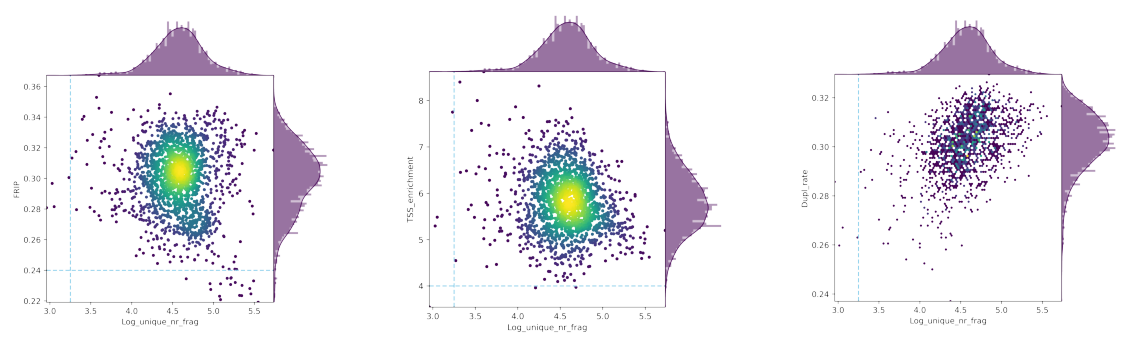

In [25]:
runID = 'D00357'
print(f"filter for sample: {runID}")
fig=plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_figDict[runID]) #To convert figures to plot together, see .utils.py
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_figDict[runID])
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_figDict[runID])
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Select cells passing filters

In [26]:
bc_passing_filters = dict()
for runID in metadata_bc:
    bc_passing_filters[runID] = list((set(FRIP_NR_FRAG_filterDict[runID]) & set(TSS_NR_FRAG_filterDict[runID])))
    print(f"{len(bc_passing_filters[runID])} barcodes passed filters for sample {runID}")


1758 barcodes passed filters for sample D00357


In [32]:
# pickle.dump(bc_passing_filters, open('scenicplus/scATAC/quality_control/bc_passing_filters.pkl'), 'wb')
import pickle
with open(work_dir +'scATAC/quality_control/bc_passing_filters.pkl', 'wb') as f:
  pickle.dump(bc_passing_filters, f)

# Creating a cisTopic object and topic modeling

In [33]:
work_dir

'./scenicplus/'

In [34]:
import pickle

#note we use twice the same regions!
path_to_regions = {'D00357': os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')
#                   ,'MMlines_7': os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')
                  }
path_to_blacklist='../../../extra_analysis/SCENIC+/pycisTopic/blacklist/mm10-blacklist.v2.bed'

metadata_bc = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'rb'))

In [36]:
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions[key],
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc[key],
                                               valid_bc=bc_passing_filters[key],
                                               n_cpu=1,
                use_polars=False,# True gives TypeError: __init__() got an unexpected keyword argument 'encoding'
                                               project=key) for key in fragments_dict.keys()]

2023-01-26 09:08:38,296 cisTopic     INFO     Reading data for D00357
2023-01-26 09:09:42,205 cisTopic     INFO     metrics provided!
2023-01-26 09:09:45,910 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-26 09:09:51,012 cisTopic     INFO     Counting fragments in regions
2023-01-26 09:10:10,488 cisTopic     INFO     Creating fragment matrix
2023-01-26 09:45:49,723 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-26 09:45:53,554 cisTopic     INFO     Removing blacklisted regions
2023-01-26 09:45:54,824 cisTopic     INFO     Creating CistopicObject
2023-01-26 09:45:55,743 cisTopic     INFO     Done!


In [37]:
cistopic_obj = merge(cistopic_obj_list)
print(cistopic_obj)

CistopicObject from project cisTopic_merge with n_cells × n_regions = 1758 × 321250


In [46]:
import scrublet as scr
scrub = scr.Scrublet(cistopic_obj.fragment_matrix.T, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.call_doublets(threshold=0.3)
scrub.plot_histogram()
scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.08
Detected doublet rate = 95.8%
Estimated detectable doublet fraction = 96.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 99.0%
Elapsed time: 7.1 seconds
Detected doublet rate = 20.8%
Estimated detectable doublet fraction = 38.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 54.6%


In [48]:
cistopic_obj.add_cell_data(scrublet)

In [50]:
singlets = cistopic_obj.cell_data[cistopic_obj.cell_data.Predicted_doublets_fragments == False].index.tolist()
cistopic_obj = cistopic_obj.subset(singlets, copy=True)



In [51]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

###  Run topic modeling



In [52]:
import pickle
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.cistopic_class import *
sys.stderr = open(os.devnull, "w")  # silence stderr
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,5,10,15,30,45],
                    n_cpu=6,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = os.path.join(tmp_dir + 'ray_spill'))
sys.stderr = sys.__stderr__  # unsilence stderr


(run_cgs_model pid=61353) 2023-01-26 10:00:00,535 cisTopic     INFO     Running model with 15 topics
(run_cgs_model pid=61349) 2023-01-26 10:00:00,537 cisTopic     INFO     Running model with 5 topics
(run_cgs_model pid=61351) 2023-01-26 10:00:00,539 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=61354) 2023-01-26 10:00:00,535 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=61352) 2023-01-26 10:00:00,617 cisTopic     INFO     Running model with 30 topics
(run_cgs_model pid=61350) 2023-01-26 10:00:00,872 cisTopic     INFO     Running model with 45 topics
(run_cgs_model pid=61354) 2023-01-26 10:08:50,481 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=61349) 2023-01-26 10:11:23,165 cisTopic     INFO     Model with 5 topics done!
(run_cgs_model pid=61351) 2023-01-26 10:14:06,693 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=61353) 2023-01-26 10:15:16,074 cisTopic     INFO     Model with 15 topics done!
(r

In [53]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    os.makedirs(os.path.join(work_dir, 'scATAC/models'))

pickle.dump(models,
    open(os.path.join(work_dir, 'scATAC/models/mix_mm_models_500_iter_LDA.pkl'), 'wb'))

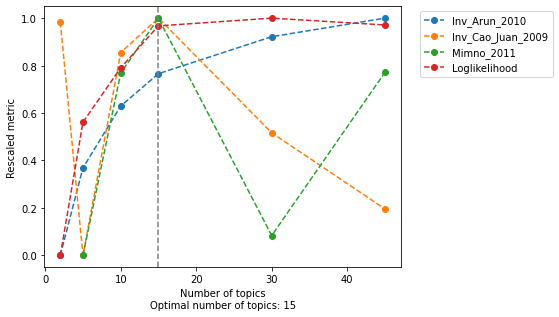

In [56]:
# Model selection

numTopics = 15
model = evaluate_models(models,
                     select_model = numTopics,
                     return_model = True,
                     metrics = ['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics = False)

In [58]:
# Add model to cistopic object.

cistopic_obj.add_LDA_model(model)

pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

In [95]:
# Visualization

from pycisTopic.clust_vis import run_umap
color_dict_line = {
    'Postmitotic premature neurons': '#00BFC4',
    'Primitive erythroid lineage': '#C77CFF',
    'Chondrocytes & osteoblasts': '#F8766D',
#     'MM074': '#222E50',
#     'MM087': '#8BB174',
#     'MM057': '#2A4849',
#     'MM050': '#626868',
#     'MM029': '#3E5641',
#     'MM047': '#59A96A',
#     'MM099': '#56E39F',
    'Intermediate Mesoderm': '#7CAE00'
}
run_umap(cistopic_obj, target = 'cell', scale = True)

2023-01-26 11:15:10,194 cisTopic     INFO     Running UMAP


In [96]:
# Adding metadata to a cisTopic object


cistopic_obj.add_cell_data(cell_data, split_pattern='___')


Columns ['nMonoFrags', 'PromoterRatio', 'barcodes', 'ReadsInPromoter', 'Clusters', 'predictedCell_Un', 'ReadsInBlacklist', 'orig.ident', 'predictedGroup_Un', 'nMultiFrags', 'BlacklistRatio', 'PassQC', 'NucleosomeRatio', 'nDiFrags', 'nFrags', 'Sample', 'ReadsInTSS', 'nCount_Spatial', 'cellID_archr', 'predictedScore_Un', 'nFeature_Spatial', 'TSSEnrichment'] will be overwritten


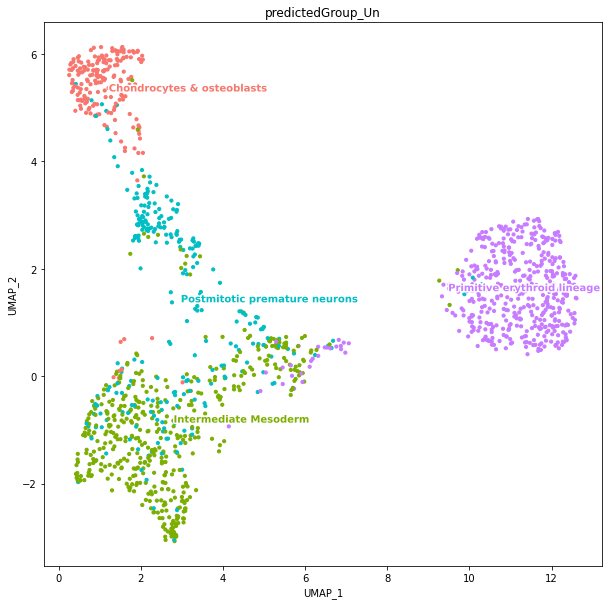

In [99]:
from pycisTopic.clust_vis import plot_metadata
plot_metadata(
    cistopic_obj,
    reduction_name = 'UMAP',
    color_dictionary = {'predictedGroup_Un': color_dict_line},
    variables = ['predictedGroup_Un'],
    figsize = (10, 10))

# Inferring candidate enhancer regions

Next we will infer candidate enhancer regions by binarization of region-topic probabilities and calculating differentially accessible regions.

These regions will be used for the next step, pycistarget, in that we will look which motifs are enriched in these regions.

This approach is the same as we would do with multiome data.

In the interest of time, will only use the otsu method in this case for topic binarization.



In [100]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')

### Differentially Accessible Regions (DARs)

In [101]:
from pycisTopic.diff_features import *

imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)

normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)


2023-01-26 11:20:28,821 cisTopic     INFO     Imputing drop-outs
2023-01-26 11:20:31,187 cisTopic     INFO     Scaling
2023-01-26 11:20:32,578 cisTopic     INFO     Keep non zero rows
2023-01-26 11:20:33,667 cisTopic     INFO     Imputed accessibility sparsity: 0.0570420068091948
2023-01-26 11:20:33,668 cisTopic     INFO     Create CistopicImputedFeatures object
2023-01-26 11:20:33,668 cisTopic     INFO     Done!
2023-01-26 11:20:33,669 cisTopic     INFO     Normalizing imputed data
2023-01-26 11:20:46,992 cisTopic     INFO     Done!
2023-01-26 11:20:46,996 cisTopic     INFO     Calculating mean
2023-01-26 11:20:48,145 cisTopic     INFO     Calculating variance
2023-01-26 11:20:55,921 cisTopic     INFO     Done!


In [102]:
print('Calculating DARs for each state...')
markers_dict_state = find_diff_features(cistopic_obj
                                        , imputed_acc_obj
                                        , variable='predictedGroup_Un'
                                        , var_features=variable_regions
                                        , split_pattern = '___')


Calculating DARs for each state...
2023-01-26 11:22:52,540 cisTopic     INFO     Formatting data for Chondrocytes & osteoblasts
2023-01-26 11:22:53,836 cisTopic     INFO     Computing p-value for Chondrocytes & osteoblasts
2023-01-26 11:23:38,667 cisTopic     INFO     Computing log2FC for Chondrocytes & osteoblasts
2023-01-26 11:23:41,395 cisTopic     INFO     Chondrocytes & osteoblasts done!
2023-01-26 11:23:41,423 cisTopic     INFO     Formatting data for Intermediate Mesoderm
2023-01-26 11:23:42,714 cisTopic     INFO     Computing p-value for Intermediate Mesoderm
2023-01-26 11:24:26,737 cisTopic     INFO     Computing log2FC for Intermediate Mesoderm
2023-01-26 11:24:29,371 cisTopic     INFO     Intermediate Mesoderm done!
2023-01-26 11:24:29,409 cisTopic     INFO     Formatting data for Postmitotic premature neurons
2023-01-26 11:24:30,640 cisTopic     INFO     Computing p-value for Postmitotic premature neurons
2023-01-26 11:25:14,648 cisTopic     INFO     Computing log2FC for Po

In [103]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))

pickle.dump(markers_dict_state, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict_state.pkl'), 'wb'))


# Motif enrichment analysis using pycistarget

In [104]:
import pickle
region_bin_topics_otsu = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'rb'))
markers_dict_state = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict_state.pkl'), 'rb'))


In [ ]:
# Convert to dictionary of pyranges objects.

# 

In [109]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['DARs_state'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict_state.keys():
    regions = markers_dict_state[DAR].index[markers_dict_state[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs_state'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))
for key in region_sets.keys():
    print(f'{key}: {region_sets[key].keys()}')

topics_otsu: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15'])
DARs_state: dict_keys(['Chondrocytes & osteoblasts', 'Intermediate Mesoderm', 'Postmitotic premature neurons', 'Primitive erythroid lineage'])


In [ ]:
# because of large size data base we run this on ec2

In [ ]:
rankings_db = os.path.join('/home/ec2-user/pycisTopic/notebooks/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather')
scores_db =  os.path.join('/home/ec2-user/pycisTopic/notebooks/mm10_screen_v10_clust.regions_vs_motifs.scores.feather')
motif_annotation = os.path.join('/home/ec2-user/pycisTopic/notebooks/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl')

In [ ]:
from scenicplus.wrappers.run_pycistarget import run_pycistarget
sys.stderr = open(os.devnull, "w")  # silence stderr
run_pycistarget(
    region_sets = region_sets,
    species = 'mus_musculus', #'homo_sapiens',
    save_path = os.path.join(work_dir, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 6,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    annotation_version = 'v10nr_clust')

sys.stderr = sys.__stderr__  # unsilence stderr

In [6]:
import dill
menr = dill.load(open(os.path.join(work_dir, 'scATAC/motifs/menr.pkl'), 'rb'))

In [7]:
menr.keys()

dict_keys(['CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_DARs_state_All', 'CTX_DARs_state_No_promoters', 'DEM_DARs_state_All', 'DEM_DARs_state_No_promoters'])

In [8]:
menr['DEM_DARs_state_All'].DEM_results('Chondrocytes & osteoblasts')


,Logo,Contrast,Direct_annot,Orthology_annot,Log2FC,Adjusted_pval,Mean_fg,Mean_bg,Motif_hit_thr,Motif_hits
taipale_tf_pairs__HOXB2_TCF3_NCACCTGNNNNNMATTA_CAP_repr,,Chondrocytes & osteoblasts,NaN,"Tcf3, Hoxb2",0.94803,0.007467,0.572181,0.296584,3.0,951.0
metacluster_152.2,,Chondrocytes & osteoblasts,NaN,Twist1,0.879799,0.009462,1.186364,0.644721,3.0,2061.0
metacluster_9.4,,Chondrocytes & osteoblasts,Pax7,NaN,0.721521,0.033642,0.60121,0.364608,3.0,694.0
metacluster_20.9,,Chondrocytes & osteoblasts,NaN,Tlx2,0.648391,0.02865,0.727211,0.463955,3.0,1187.0
swissregulon__hs__PRRX2,,Chondrocytes & osteoblasts,NaN,Prrx2,0.572629,0.002317,0.884192,0.594522,3.0,1163.0
metacluster_15.1,,Chondrocytes & osteoblasts,E2f4,"E2f4, E2f7",0.548105,0.005626,0.669967,0.458202,3.0,709.0
metacluster_15.3,,Chondrocytes & osteoblasts,E2f3,"E2f6, Tfdp1, E2f1, E2f8",0.533037,0.0063,0.539074,0.372553,3.0,618.0
swissregulon__hs__CHD1,,Chondrocytes & osteoblasts,NaN,Chd1,0.52351,0.019543,0.954534,0.664048,3.0,1504.0
cisbp__M07938,,Chondrocytes & osteoblasts,NaN,E2f1,0.508679,0.015075,0.566164,0.397938,3.0,641.0


We now have completed all the steps necessary for starting the SCENIC+ analysis 😅.

In particalular, we have

preprocessed the scRNA-seq side of the data, selecting high quality cells and annotation these cells.

preprocessed the scATAC-seq side of the data, selecting high quality cells, performing topic modeling and identifying candidate enhacer regions.

looked for enriched motifs in candidate enhancer regions.

In the next section we will combine all these analysis and run SCENIC+